# Contents

* Probability distributions seems to discern a bit. 
* There are some small overlapings could be due to the number of topics choseen .
* Not sure whether word embedings can perform well on our "two short" sentences. 
* Looking at the topics seem common words appear across al topics and just one or two differ

# Setup

In [17]:
import re
from collections import Counter
import pandas as pd
import numpy as np
import gensim
from gensim.models.ldamulticore import LdaMulticore
import nltk
import matplotlib.pyplot as plt

# Raw dataset

In [18]:
data = pd.read_csv('../../data/processed/cleanedDataV2.csv')

In [19]:
data.head()

,textID,text,sentiment
0,cb774db0d1,"['respond', 'go']",neutral
1,549e992a42,"['sad', 'miss']",negative
2,088c60f138,"['boss', 'bully']",negative
3,9642c003ef,"['interview', 'leave', 'alone']",negative
4,358bd9e861,"['son', 'put', 'release', 'already', 'buy']",negative


In [20]:
data = data.dropna().reset_index()

In [21]:
data.isnull().sum()

index        0
textID       0
text         0
sentiment    0
dtype: int64

# Parse data

In [22]:
#Convert list of tokens to string
list_corpus = []
for sentence in data['text']:
    tokens = sentence.replace("[","").replace("]","").replace("'","").replace(",","")
    list_corpus.append(tokens)
data['text'] = list_corpus

In [23]:
data['text'] = data.text.apply(lambda x: x.split(' '))

## Vectorize words

In [29]:
def document_to_bow(df, column):
    # create dict
    dictionary = gensim.corpora.Dictionary(df[column])
    print(dictionary)
    # filtering low count 
    dictionary.filter_extremes(no_above=0.8, no_below=3)
    # Reindexes the remaining words after filtering 
    dictionary.compactify()
    print("Left with {} words.".format(len(dictionary.values())))
    # Make a BOW for every document
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df[column]))
    return dictionary

In [30]:
dictionary = document_to_bow(data, 'text')
data.head()

Dictionary(9652 unique tokens: ['go', 'respond', 'miss', 'sad', 'boss']...)
Left with 4116 words.


,index,textID,text,sentiment,bow
0,0,cb774db0d1,"[respond, go]",neutral,"[(0, 1), (1, 1)]"
1,1,549e992a42,"[sad, miss]",negative,"[(2, 1), (3, 1)]"
2,2,088c60f138,"[boss, bully]",negative,"[(4, 1), (5, 1)]"
3,3,9642c003ef,"[interview, leave, alone]",negative,"[(6, 1), (7, 1), (8, 1)]"
4,4,358bd9e861,"[son, put, release, already, buy]",negative,"[(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]"


## LDA model

In [31]:
# LDA (training)
def training_lda(num_topics, corpus=data.bow, id2word=dictionary):
    #A multicore approach to decrease training time
    LDAmodel = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=num_topics,
                            workers=4,
                            chunksize=2000,
                            passes=7,
                            alpha='asymmetric')
    return LDAmodel

# LDA topic inspection
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

# Plot funcion

In [32]:
def ploting_topics_distributions(pos_topic_dist, neg_topic_dist, neu_topic_dis, *, num_topics, ylim=0.06,):
    fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))

    nr_top_bars = 5
    ax1.set_title("Pos sentiment distributions", fontsize=16)
    ax2.set_title("Neg sentiment distributions", fontsize=16)
    ax3.set_title("Neu sentiment distributions", fontsize=16)
    ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
             rotation="vertical")

    for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [pos_topic_dist,neg_topic_dist,neu_topic_dis],
                                   ['b','g','r']):
        # Individual distribution barplots
        ax.bar(range(len(distribution)), distribution, alpha=0.7)
        rects = ax.patches
        for i in np.argsort(distribution)[-nr_top_bars:]:
            rects[i].set_color(color)
            rects[i].set_alpha(1)
        # General plotting adjustments
        ax.set_xlim(-1, 50)
        ax.set_xticks(range(0, num_topics+1, 5))
        ax.set_xticklabels(range(0,num_topics+1, 5), fontsize=16)
        ax.set_ylim(0,ylim)
        ax.set_yticks([0,ylim/2,ylim])
        ax.set_yticklabels([0,ylim/2,ylim], fontsize=16)

        fig.tight_layout(h_pad=3.)


# LDA topic inspection

In [33]:
LDAmodel100 = training_lda(num_topics = 100)

data['lda_features100'] = list(map(
    lambda doc: document_to_lda_features(LDAmodel100, doc),
    data.bow))

## Topics distribution

C:\Users\Elia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


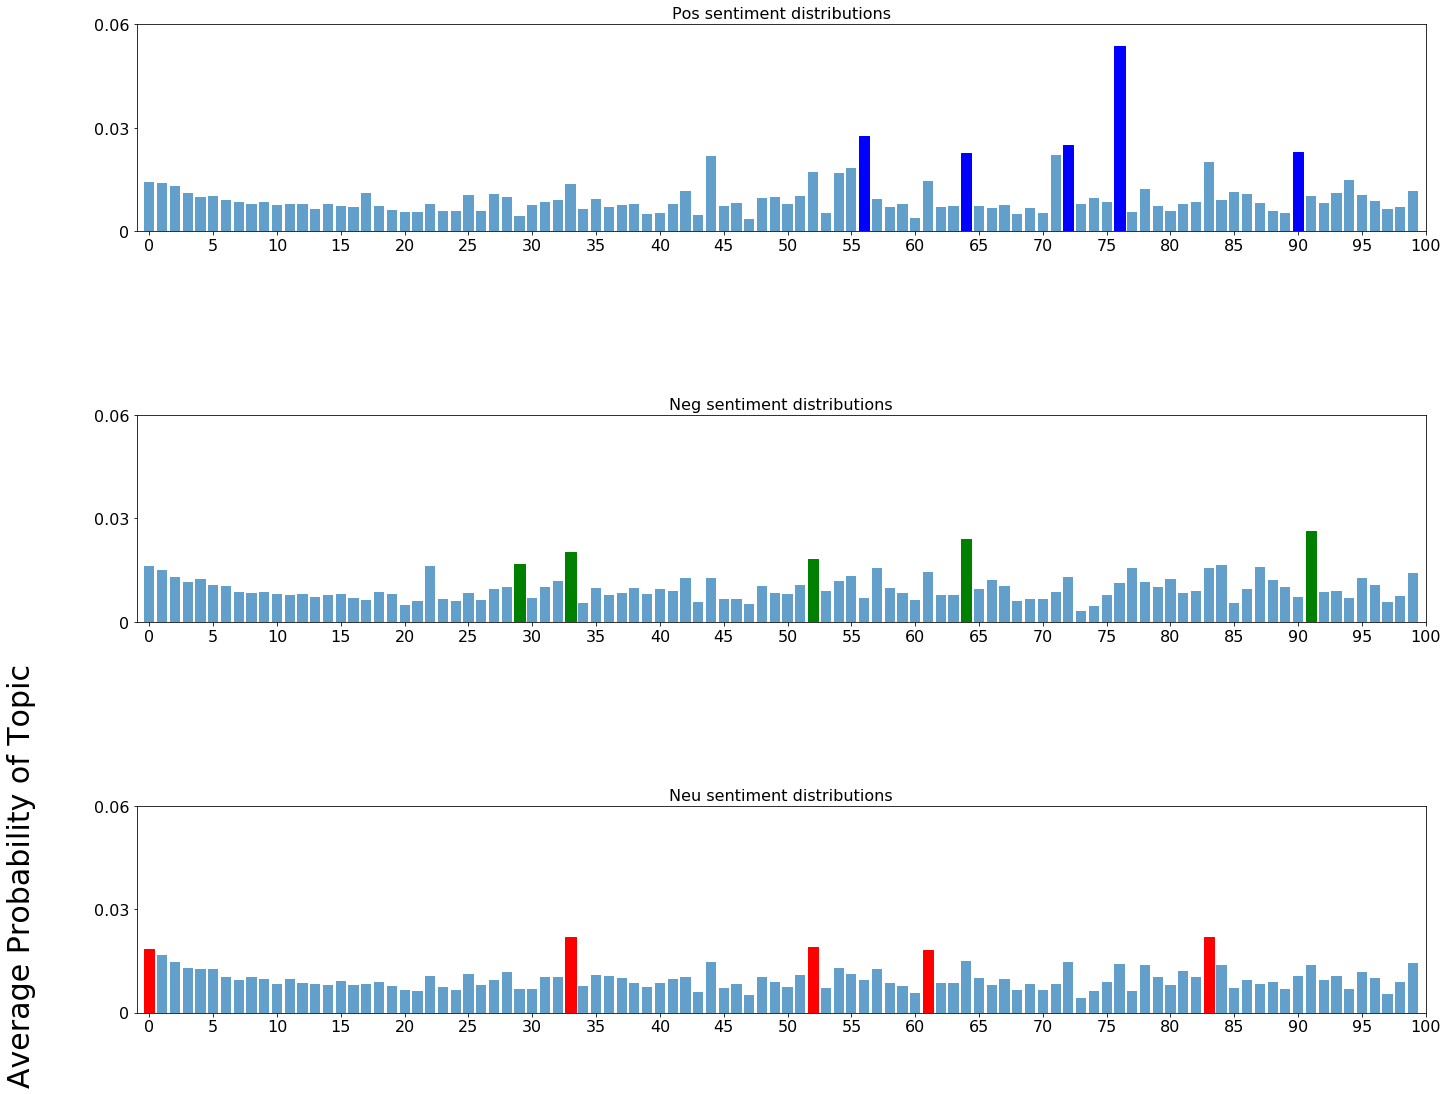

In [35]:
pos_top_dist = data.loc[data.sentiment == 'positive', 'lda_features100'].mean()
neg_top_dist = data.loc[data.sentiment == 'negative', 'lda_features100'].mean()
neu_top_dist = data.loc[data.sentiment == 'neutral', 'lda_features100'].mean()
ploting_topics_distributions(pos_top_dist, neg_top_dist, neu_top_dist, num_topics=100)

# Printing topics found

In [36]:
for i,topic in LDAmodel100.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.024*"not" + 0.020*"get" + 0.017*"go" + 0.016*"background" + 0.016*"new" + 0.014*"blast" + 0.014*"angry" + 0.012*"horror" + 0.012*"ran" + 0.012*"idiot"

1: 0.019*"apps" + 0.019*"like" + 0.018*"awe" + 0.016*"need" + 0.012*"crave" + 0.012*"get" + 0.012*"much" + 0.012*"central" + 0.012*"butter" + 0.011*"today"

2: 0.028*"congratulation" + 0.021*"bummer" + 0.021*"time" + 0.020*"today" + 0.020*"like" + 0.019*"get" + 0.017*"kitchen" + 0.017*"bio" + 0.016*"rite" + 0.015*"cleaning"

3: 0.039*"depress" + 0.039*"not" + 0.035*"kick" + 0.022*"like" + 0.021*"know" + 0.018*"sent" + 0.017*"good" + 0.016*"base" + 0.016*"escape" + 0.016*"mon"

4: 0.027*"make" + 0.026*"milk" + 0.026*"get" + 0.025*"consider" + 0.023*"thru" + 0.020*"time" + 0.017*"buddy" + 0.017*"lack" + 0.017*"snap" + 0.017*"swear"

5: 0.039*"indeed" + 0.034*"blah" + 0.020*"laundry" + 0.020*"positive" + 0.019*"freeze" + 0.017*"need" + 0.016*"hurry" + 0.016*"typical" + 0.015*"replace" + 0.015*"today"

6: 0.033*"marry" + 0.028*"daddy" 

In [45]:
LDAmodel100.num_terms

4116

In [49]:
LDAmodel100.print_topic(33)

'0.343*"sleep" + 0.063*"face" + 0.060*"part" + 0.043*"get" + 0.040*"cant" + 0.038*"train" + 0.029*"time" + 0.023*"kiss" + 0.023*"need" + 0.022*"quick"'